In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shapely as shp
import scipy
from sklearn.datasets import make_moons,make_classification
from scipy.interpolate import make_interp_spline

## Voronoi diagram

\draw[fill=cyan](-0.33, 1.33)--(0.18, 1.33)--(0.38, 0.96)--(0.17, 0.82)--(-0.33, 0.93)--(-0.33, 1.33);
\draw[fill=cyan](-0.33, -0.13)--(-0.33, 0.93)--(0.17, 0.82)--(0.23, 0.71)--(-0.13, -0.07)--(-0.19, -0.13)--(-0.33, -0.13);
\draw[fill=cyan](-0.19, -0.13)--(-0.13, -0.07)--(0.42, 0.37)--(0.6, 0.31)--(0.69, 0.2)--(0.64, -0.13)--(-0.19, -0.13);
\draw[fill=orange](0.38, 0.96)--(0.57, 1.02)--(0.77, 0.78)--(0.39, 0.54)--(0.23, 0.71)--(0.17, 0.82)--(0.38, 0.96);
\draw[fill=cyan](0.23, 0.71)--(0.39, 0.54)--(0.42, 0.37)--(-0.13, -0.07)--(0.23, 0.71);
\draw[fill=orange](0.6, 1.33)--(0.6, 1.14)--(0.57, 1.02)--(0.38, 0.96)--(0.18, 1.33)--(0.6, 1.33);
\draw[fill=cyan](0.57, 1.02)--(0.6, 1.14)--(1.6, 1.14)--(1.36, 0.88)--(0.96, 0.72)--(0.87, 0.73)--(0.77, 0.78)--(0.57, 1.02);
\draw[fill=orange](0.64, -0.13)--(0.69, 0.2)--(0.83, 0.24)--(1.2, -0.13)--(0.64, -0.13);
\draw[fill=orange](0.87, 0.73)--(0.6, 0.31)--(0.42, 0.37)--(0.39, 0.54)--(0.77, 0.78)--(0.87, 0.73);
\draw[fill=orange](0.6, 0.31)--(0.87

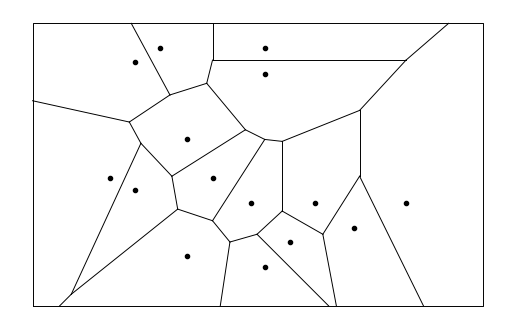

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shapely as shp

#n_points = 15
#random_points = [(random.randint(0,25),random.randint(0,18)) for i in range(n_points)]

random_points = [
    (13, 18),
    (3, 17),
    (17, 6),
    (13, 1),
    (7, 11),
    (3, 7),
    (12, 6),
    (9, 8),
    (13, 16),
    (20, 4),
    (1, 8),
    (5, 18),
    (24, 6),
    (7, 2),
    (15, 3)
]

scale = 15
random_points = [(rp[0]/scale,rp[1]/scale) for rp in random_points]
random_points = [(round(rp[0],2),round(rp[1],2)) for rp in random_points]

voronoi = shp.voronoi_polygons(
    shp.MultiPoint(random_points),
    only_edges=True,
).geoms
voronoi = list(voronoi)

min_x, max_x = -5, 30
min_y, max_y = -2, 20
min_x, max_x = round(min_x/scale,2), round(max_x/scale,2)
min_y, max_y = round(min_y/scale,2), round(max_y/scale,2)

coords = [(min_x,min_y),(max_x,min_y),(max_x,max_y),(min_x,max_y),(min_x,min_y)]
plane = shp.Polygon(coords)
voronoi = [plane.intersection(v) for v in voronoi]
voronoi = [v for v in voronoi if v]

rounded = [list(p.coords) for p in voronoi]
rounded = [
    [(round(p2[0],2),round(p2[1],2)) for p2 in p] 
    for p in rounded
]

for r in rounded:
    plt.plot(
        [r2[0] for r2 in r],
        [r2[1] for r2 in r],
        'k',
        linewidth=.7
    )
for p in random_points:
    plt.plot(p[0],p[1], '.k')

plt.plot(*plane.exterior.xy,'k',linewidth=.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_axis_off()

def poly_to_coords(P):
    return [(round(x[0],2),round(x[1],2)) for x in list(P.exterior.coords)]

voronoi_areas = shp.voronoi_polygons(
    shp.MultiPoint(random_points)
).geoms
voronoi_areas = list(voronoi_areas)
voronoi_areas = [plane.intersection(v) for v in voronoi_areas]
voronoi_areas = [v for v in voronoi_areas if v]

to_str = lambda el: [str(x) for x in poly_to_coords(el)]
for va in voronoi_areas:
    print(f'\\draw[fill={"orange" if random.randint(0,1)==1 else "cyan"}]{"--".join(to_str(va))};')

#for p in rounded:
#    print(f'\\draw {p[0]} -- {p[1]};')

points = "--".join(
    [str(x) for x in 
     [(min_x,min_y),(max_x,min_y),
      (max_x,max_y),(min_x,max_y),
      (min_x,min_y)]]
)
print(f'\\draw {points};')

for p in random_points:
    print(f'\\node at {p} {"{textbullet}"};'.replace('{','{\\'))

# NN

In [7]:
class kNN:
    def __init__(self, k, X, Y):
        self.k = k
        self.d = len(X[0])
        self.m = len(X)
        self.SX = X #ordered data points
        self.SY = Y #ordered labels associated with SX
    
    def distance(self,a,b):
        return np.sqrt(sum((a-b)**2)) 
    
    def max_freq(self,l):
        freq = {el:len([1 for x in l if x==el]) for el in l}
        return max(freq, key=freq.get)

    def distances(self, x):
        np_x = np.array(x)
        return sorted(
            [(i,self.distance(np_x,xt)) for i,xt in enumerate(self.SX)],
            key=lambda n: n[1]
        )

    def predict(self,x):
        np_x = np.array(x)
        distances = sorted(
            [(i,self.distance(np_x,xt),self.SY[i]) for i,xt in enumerate(self.SX)],
            key=lambda n: n[1]
        )
        return self.max_freq([d[2] for d in distances][:self.k])
    
    def test_error(self, TSX, TSY):
        return sum([int(TSY[t]!=self.predict(TSX[t])) for t in range(len(TSX))])/len(TSX)

    def lS(self):
        return sum([int(self.SY[t]!=self.predict(self.SX[t])) for t in range(self.m)])/self.m

In [34]:
X, y = make_classification(
    n_samples = 2000, 
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True
)

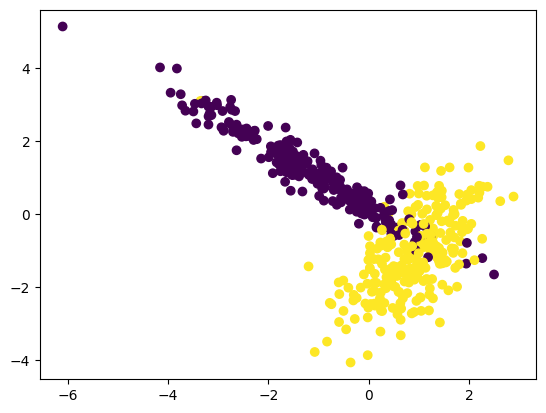

In [40]:
SX, SY = X[:-500], y[:-500]
TX, TY = X[-500:], y[-500:]

# Plot the generated datasets
plt.scatter(TX[:, 0], TX[:, 1], c=TY)
plt.show()

In [37]:
x = []
for k in range(1,51):
    h = kNN(k,SX*30,SY)
    x.append(h.lS())

In [38]:
test_error = []
for k in range(1,51):
    h = kNN(k,SX*30,SY)
    test_error.append(h.test_error(TX,TY))

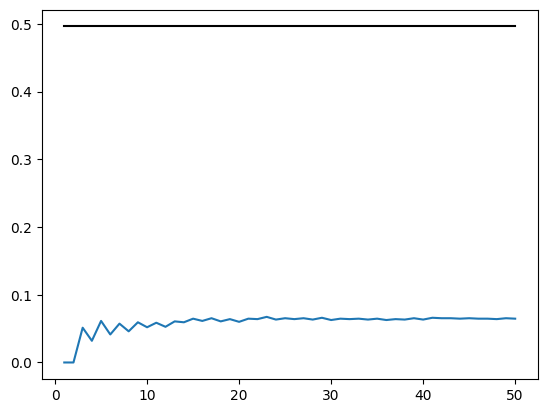

In [39]:
plt.plot(range(1,51),x,'')
plt.plot(range(1,51),test_error,'-k')

In [3]:
T = {'s':'sole', 'r':'pioggia'}
U = {'h':'alta', 'n':'bassa'}
V = {1:'sì', 0:'no'}
Y = {0:'-1', 1:'1'}

S = [
    # p   u  v y
    ('s','h',0,0),
    ('s','h',1,0),
    ('r','h',0,1),
    ('r','n',0,1),
    ('r','n',1,0),
    ('s','n',0,1),
    ('s','n',1,1)
]

for s in S:
    print(f'{T[s[0]]} & {U[s[1]]} & {V[s[2]]} & {Y[s[3]]}\\\\')

sole & alta & no & -1\\
sole & alta & sì & -1\\
pioggia & alta & no & 1\\
pioggia & bassa & no & 1\\
pioggia & bassa & sì & -1\\
sole & bassa & no & 1\\
sole & bassa & sì & 1\\
